In [1]:
%matplotlib inline
import os, numpy, csv
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from numpy import mean,std
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,SparsePCA,MiniBatchSparsePCA,TruncatedSVD
from sklearn.externals import joblib as pickle
from sklearn.decomposition import RandomizedPCA as RCA
from paramRegressor import *

### Loading the dictionary from pickle

In [3]:
def loadData(name,path):
    '''
    This loads a pickle file and returns the content which is a DICTIONARY object in our case.
    '''
    if ".pkl" in name:
            name = name.split(".pkl")[0]
    if "/" in name:
            name = name.split("/",1)[1]

    with open(path+"/"+name + '.pkl', 'rb') as f:
          return pickle.load(f)

### Saving the dictionary in pickle

In [2]:
def saveData(obj, name,path):
    '''
    This saves a object into a pickle file. In our case, it is generally a DICTIONARY object.
    '''

    with open(path+"/"+name + '.pkl', 'wb') as f:
            pickle.dump(obj, f)#, pickle.HIGHEST_PROTOCOL)

### Finds the first Index of a sorted List which is above certain value

In [10]:
def firstIndexAbove(alist,x):
    return [ n for n,i in enumerate(alist) if float(i)>x ][0]

### Returns first 3 significant digits of a float

In [4]:
def ThreeSig(x):
    return float("{0:.3f}".format(x))

### Creates a filtered dictionary based on selected keys 

In [12]:
def include_keys(dictionary, keys):
    """Filters a dict by only including certain keys."""
    key_set = set(keys) & set(dictionary.keys())
    return {key: dictionary[key] for key in key_set}

### It returns a dictionary from a pickle folder

In [13]:
def returnDictFromPkls(directory):
    dictionary = {}
    for File in os.listdir(directory):
        if ".pkl" in File:
            key = File.split("_")[1]
            dictionary[key] = loadData(File,directory)
    return dictionary     

### It finds out algorithms which have more R2 >0.5

In [14]:
def findGoodR2Scores(directory):
    dictionary = returnDictFromPkls(directory)
    cleanedDictionary = {}
    for key in dictionary:
        if dictionary[key]['r2']>0.5:
            cleanedDictionary[key] = dictionary[key]
    return cleanedDictionary

### It extracts all pickles for a functional and returns a dictionary

In [15]:
def returnCompleteDictFromPkls(directory):
    dictionary = {}
    for folder in os.listdir(directory):
        subdirectory = directory+"/"+folder
        dct = {}
        if ".DS_Store" in subdirectory:
            continue
        for File in os.listdir(subdirectory):
            if ".pkl" in File:
                innerkey = File.split("_")[1]
                dct[innerkey] = loadData(File,subdirectory)
                
        dictionary[folder] = dct
    return dictionary   
    

### Generic code to plot a scatterplot with line of best fit

In [13]:
def scatterplot(realY,predictedY,title="test"):
    x = realY
    y = predictedY
    
    fig = plt.figure()
    
    fig.suptitle(title, fontsize=18)
    plt.xlabel('actualHOMO', fontsize=16)
    plt.ylabel('predictedHOMO', fontsize=16)
    
    plt.plot(x, numpy.poly1d(numpy.polyfit(x, y, 1))(x),color='red')
    plt.scatter(x,y)
#     figName = title.split("(")[0]+".png"
#     fig.savefig(figName, bbox_inches='tight')
#     plt.close(fig)

### Plots scatterplot for a particular algorithm

In [10]:
def plotScatter(realY, dct,fingerprint,algorithm):
    key = fingerprint
    dictionary = dct[key]
    predictedY = dictionary[algorithm]['predicted']
    r2 = str(float("{0:.3f}".format(dictionary[algorithm]['r2'])))
    R2 = "(R"+r'$^2$'+"="+r2+")"
    title = functional+"_"+key+"_"+algorithm+R2
    scatterplot(realY,predictedY,title=title)

### It creates a csv file with all regressed metrics across all fingerprints for a functional

In [18]:
def createDataTable(functional):
    dictionary = returnCompleteDictFromPkls(functional)
    with open(functional+'.csv', 'w') as csvfile:
        fieldnames = ['Fingerprint','algorithm','r2','r','MSE','RMSE','MAE','MAPE']
        emptyRow = {}
        for key in fieldnames:
            emptyRow[key] =''
            
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for key in dictionary.keys():
            headerRow = {}
            for item in fieldnames:
                headerRow[item]= ''
            headerRow['Fingerprint'] = key

            writer.writerow(headerRow)
            innerDict = dictionary[key]
            for innerkey in innerDict.keys():
                dct = innerDict[innerkey]
                dct['Fingerprint'] =''
                dct['algorithm'] = innerkey
                filteredDict = include_keys(dct,fieldnames)
                writer.writerow(filteredDict)

            writer.writerow(emptyRow)
        


### Creates a csv from a pickle (across all algorithms)

In [19]:
def createCSV(functional,fingerprint,algorithm):
    dictionary = returnCompleteDictFromPkls(functional)
    innerDict = dictionary[fingerprint][algorithm]
    realY = loadData('y_full_'+functional,'FP')
    predictedY = innerDict['predicted']
    dctList  = []
    for i in range(len(realY)):
        dct = {}
        dct['ExcelID'] = i+1
        dct['functionalHOMO'] = realY[i]
        dct['predictedHOMO'] = predictedY[i]
        dctList += [dct]
    
    csvName = functional+"_"+fingerprint+"_"+algorithm+".csv"
    with open(csvName, 'w') as csvfile:
        fieldnames = ['ExcelID','functionalHOMO','predictedHOMO']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for dct in dctList:
            writer.writerow(dct)
    


### Creates a set of csvs (calls create CSV across all fuctionals and fingerprints)

In [20]:
def createAllCSVs(functional):
    dictionary = returnCompleteDictFromPkls(functional)
    for fingerprint in dictionary.keys():
        fingerprintDct = dictionary[fingerprint]
        for algorithm in fingerprintDct.keys():
            createCSV(functional,fingerprint,algorithm)

### Makes sub-directories for all the 4 different fingerprints in the directory path (for each functional)

In [21]:
def makeNewDir(path):
    if not os.path.exists(path):
        os.makedirs(path)
    fingerprints = ['MACCS','Circular','Topological','AtomPair']
    for fingerprint in fingerprints:
        directory = path+"/"+fingerprint
        if not os.path.exists(directory):
            os.makedirs(directory)

### Creates the scatterplots across all fingerprints and algorithms for a given functional

In [22]:
def createAllPlots(functional):
    dictionary = returnCompleteDictFromPkls(functional)
    for fingerprint in dictionary.keys():
        fingerprintDct = dictionary[fingerprint]
        for algorithm in fingerprintDct.keys():
            realY = loadData('y_full_'+functional,'FP')
            plotScatter(realY, dictionary,fingerprint,algorithm)

In [23]:
functional = 'M06'
atomPair = loadData('X_full_AtomPair','FP')
topological = loadData('X_full_Topological','FP')
realY = loadData('y_full_'+functional,'FP')

atomTopo = numpy.concatenate((atomPair,topological), axis=1)

### Removing features with zero variance (or columns which are same across all rows)

In [24]:
selector = VarianceThreshold()
convertedAtomPair = selector.fit_transform(atomPair)
convertedAtomTopo = selector.fit_transform(atomTopo)

In [25]:
len(convertedAtomPair[0])

1851

In [26]:
len(convertedAtomTopo[0])

2499

### R2 values for each fingerprint (before and after removing zero variance columns)

In [27]:
fingerprints = ['B3LYP','PBE','PB86','M06']
for fp in fingerprints:
    print 
    print fp
    print "================================"
    print 'r2 for AtomPair',fp,' is',loadData('AtomPair_randomForest_'+fp+'.pkl',fp+'/AtomPair')['r2']
    print 'r2 for Topo',fp,' is',loadData('Topological_randomForest_'+fp+'.pkl',fp+'/Topological')['r2']
    print
    print 'After reduction'
    print 'r2 for AtomPair',fp,' is',loadData('selectedAtomPair_randomForest_'+fp+'.pkl','selected')['r2']
    print 'r2 for AtomTopo',fp,' is',loadData('selectedAtomTopo_randomForest_'+fp+'.pkl','selected')['r2']
    print 
    print '--------------------------------'


B3LYP
r2 for AtomPair B3LYP  is 0.665810346553
r2 for Topo B3LYP  is 0.670586876427

After reduction
r2 for AtomPair B3LYP  is 0.667571445796
r2 for AtomTopo B3LYP  is 0.685682700792

--------------------------------

PBE
r2 for AtomPair PBE  is 0.655769023726
r2 for Topo PBE  is 0.671981981143

After reduction
r2 for AtomPair PBE  is 0.660979285919
r2 for AtomTopo PBE  is 0.686222417459

--------------------------------

PB86
r2 for AtomPair PB86  is 0.642072583845
r2 for Topo PB86  is 0.682561169993

After reduction
r2 for AtomPair PB86  is 0.648924740521
r2 for AtomTopo PB86  is 0.67186794319

--------------------------------

M06
r2 for AtomPair M06  is 0.66992936286
r2 for Topo M06  is 0.661191203664

After reduction
r2 for AtomPair M06  is 0.671136327622
r2 for AtomTopo M06  is 0.684108001619

--------------------------------


### Function for plotting the cumulative variance across principal components

In [28]:
def plotEigenVariance(X_train):
    sc = StandardScaler()
    X_train_std = sc.fit_transform(X_train)
    cov_mat = np.cov(X_train_std.T)
    eigen_vals,eigen_vecs = np.linalg.eig(cov_mat)
    tot = sum(eigen_vals)
    num = len(eigen_vals)+1
    var_exp = [(i/tot) for i in sorted(eigen_vals,reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.bar(range(1,num),var_exp,alpha=0.5,align='center',label='individual explained variance')
    plt.step(range(1,num),cum_var_exp,where='mid',label='cumulative explained variance')
    plt.ylabel('explained variance ratio')
    plt.xlabel('principal components')
    plt.legend(loc='best')
    plt.show()

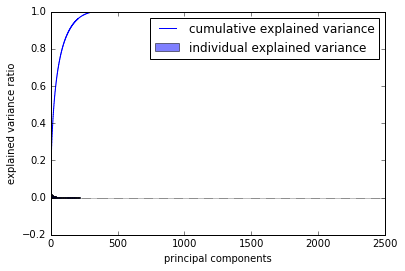

In [29]:
plotEigenVariance(convertedAtomTopo)

## For each cumulative percentage in cum_scores list, it finds the number of principal components and returns all that in a List

In [30]:
def findNumComponents(X_train_std):
    cov_mat = np.cov(X_train_std.T)
    eigen_vals,eigen_vecs = np.linalg.eig(cov_mat)
    tot = sum(eigen_vals)
    num = len(eigen_vals)+1
    var_exp = [(i/tot) for i in sorted(eigen_vals,reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    List = []
    cum_scores = [0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
    for score in cum_scores:
        List +=[firstIndexAbove(cum_var_exp,score)]
    return List
   
      

## List of functions performing transformations: PCA,  Randomized PCA, Sparse PCA  and Truncated SVD

#### PCA_transform


In [31]:
def pca_transform(X_train):
    sc = StandardScaler()
    X_list = []
    X_train_std = sc.fit_transform(X_train)
    components = findNumComponents(X_train_std)
    for component in components:
        pca = PCA(n_components=component)
        X_train_pca = pca.fit_transform(X_train_std)
        
        X_list +=[np.array(X_train_pca)]
    
        return X_list

#### Randomized PCA_transform

In [32]:
def rca_transform(X_train):
    sc = StandardScaler()
    X_list = []
    X_train_std = sc.fit_transform(X_train)
    components = findNumComponents(X_train_std)
    for component in components:
        rca = RCA(n_components=component)
        X_train_rca = rca.fit_transform(X_train_std)
        
        X_list +=[np.array(X_train_rca)]
    
    return X_list

#### Sparse PCA transform

In [33]:
def sparse_pca_transform(X_train):
    sc = StandardScaler()
    X_list = []
    X_train_std = sc.fit_transform(X_train)
    components = findNumComponents(X_train_std)
    for component in components:
        #pca = PCA(n_components=component)
        pca = MiniBatchSparsePCA(n_components=component,n_jobs=-1,batch_size=10)
        X_train_pca = pca.fit_transform(X_train_std)
        
        X_list +=[np.array(X_train_pca)]
    
        return X_list

#### Truncated SVD transformation

In [34]:
def truncatedSVD_transform(X_train):
    sc = StandardScaler()
    X_list = []
    X_train_std = sc.fit_transform(X_train)
    components = findNumComponents(X_train_std)
    for component in components:
        tsvd = TruncatedSVD(n_components=component)
        X_train_tsvd = tsvd.fit_transform(X_train_std)
        
        X_list +=[np.array(X_train_tsvd)]
    
    return X_list

In [35]:
len(rca_transform(convertedAtomTopo))

8

In [36]:
findNumComponents(convertedAtomPair)

[24, 43, 56, 74, 97, 130, 183, 270]

## R2 results after PCA, randomized PCA and before PCA (after removing no variance elements) and before any transformation


### PCA and RandomizedPCA on AtomPair

In [37]:
prefix = 'selectedAtomPair_randomForest_B3LYP_pca'

print
cum_scores = [0.3,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
for score in cum_scores:
    print 'cumulative ',score*100,'%'
    fileName = prefix +str(score)
    print "PCA:",loadData(fileName,'PCA')['r2']
    #print "RCA:",loadData(fileName.replace('pca','rca'),'RCA')['r2']
    print "Before PCA After VarianceThreshold:",loadData('selectedAtomPair_randomForest_B3LYP.pkl','selected')['r2']
    print "Before PCA Before VarianceThreshold:",loadData('AtomPair_randomForest_B3LYP.pkl','B3LYP/AtomPair')['r2']
    print


cumulative  30.0 %
PCA: 0.56983325254
Before PCA After VarianceThreshold: 0.667571445796
Before PCA Before VarianceThreshold: 0.665810346553

cumulative  40.0 %
PCA: 0.549927901771
Before PCA After VarianceThreshold: 0.667571445796
Before PCA Before VarianceThreshold: 0.665810346553

cumulative  45.0 %
PCA: 0.544647444728
Before PCA After VarianceThreshold: 0.667571445796
Before PCA Before VarianceThreshold: 0.665810346553

cumulative  50.0 %
PCA: 0.543598930442
Before PCA After VarianceThreshold: 0.667571445796
Before PCA Before VarianceThreshold: 0.665810346553

cumulative  55.0 %
PCA: 0.518792640153
Before PCA After VarianceThreshold: 0.667571445796
Before PCA Before VarianceThreshold: 0.665810346553

cumulative  60.0 %
PCA: 0.579576400804
Before PCA After VarianceThreshold: 0.667571445796
Before PCA Before VarianceThreshold: 0.665810346553

cumulative  65.0 %
PCA: 0.491750495405
Before PCA After VarianceThreshold: 0.667571445796
Before PCA Before VarianceThreshold: 0.665810346553


### PCA and Randomized PCA on AtomTopo 

In [38]:
prefix = 'selectedAtomTopo_randomForest_B3LYP_pca'
print 'AtomTopo'
print
cum_scores = [0.3,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
for score in cum_scores:
    print 'cumulative ',score*100,'%'
    fileName = prefix +str(score)
    print "PCA:",ThreeSig(loadData(fileName,'PCA')['r2'])
    #print "RCA:",ThreeSig(loadData(fileName.replace('pca','rca'),'RCA')['r2'])
    print "Before PCA After VarianceThreshold:",ThreeSig(loadData('selectedAtomTopo_randomForest_B3LYP.pkl','selected')['r2'])
    print

AtomTopo

cumulative  30.0 %
PCA: 0.574
Before PCA After VarianceThreshold: 0.686

cumulative  40.0 %
PCA: 0.578
Before PCA After VarianceThreshold: 0.686

cumulative  45.0 %
PCA: 0.565
Before PCA After VarianceThreshold: 0.686

cumulative  50.0 %
PCA: 0.547
Before PCA After VarianceThreshold: 0.686

cumulative  55.0 %
PCA: 0.521
Before PCA After VarianceThreshold: 0.686

cumulative  60.0 %
PCA: 0.575
Before PCA After VarianceThreshold: 0.686

cumulative  65.0 %
PCA: 0.506
Before PCA After VarianceThreshold: 0.686

cumulative  70.0 %
PCA: 0.565
Before PCA After VarianceThreshold: 0.686

cumulative  75.0 %
PCA: 0.56
Before PCA After VarianceThreshold: 0.686

cumulative  80.0 %
PCA: 0.55
Before PCA After VarianceThreshold: 0.686

cumulative  85.0 %
PCA: 0.534
Before PCA After VarianceThreshold: 0.686

cumulative  90.0 %
PCA: 0.5
Before PCA After VarianceThreshold: 0.686

cumulative  95.0 %
PCA: 0.487
Before PCA After VarianceThreshold: 0.686

cumulative  99.0 %
PCA: 0.473
Before PCA Afte

### Truncated Support Vector Decomposition 

In [39]:
prefix = 'selectedAtomPair_randomForest_B3LYP_tsvd'
print 'AtomPair'
print
cum_scores = [0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for score in cum_scores:
    print 'cumulative ',score*100,'%'
    fileName = prefix +str(score)
    print "TSVD:",ThreeSig(loadData(fileName,'TSVD')['r2'])
    print "PCA:",ThreeSig(loadData(fileName.replace('tsvd','pca'),'PCA')['r2'])
    print "Before PCA After VarianceThreshold:",ThreeSig(loadData('selectedAtomPair_randomForest_B3LYP.pkl','selected')['r2'])
    print

AtomPair

cumulative  30.0 %
TSVD: 0.577
PCA: 0.57
Before PCA After VarianceThreshold: 0.668

cumulative  40.0 %
TSVD: 0.557
PCA: 0.55
Before PCA After VarianceThreshold: 0.668

cumulative  50.0 %
TSVD: 0.546
PCA: 0.544
Before PCA After VarianceThreshold: 0.668

cumulative  60.0 %
TSVD: 0.531
PCA: 0.58
Before PCA After VarianceThreshold: 0.668

cumulative  70.0 %
TSVD: 0.532
PCA: 0.548
Before PCA After VarianceThreshold: 0.668

cumulative  80.0 %
TSVD: 0.498
PCA: 0.54
Before PCA After VarianceThreshold: 0.668

cumulative  90.0 %
TSVD: 0.483
PCA: 0.504
Before PCA After VarianceThreshold: 0.668



### RandomForest results after and before standardization

In [40]:
fileName ='AtomPair_randomForest_B3LYP_standard.pkl'
print "Standardized AtomPair_randomForest_B3LYP :",loadData(fileName,'regMetrics')['r2']
fileName = 'AtomPair_randomForest_B3LYP.pkl'
print "AtomPair_randomForest_B3LYP (without standardization) :",loadData(fileName,'B3LYP/AtomPair')['r2']
print "AtomPair_randomForest_B3LYP (without standardization) :",loadData(fileName,'B3LYP/AtomPair')['best_estimator']

Standardized AtomPair_randomForest_B3LYP : 0.663711837839
AtomPair_randomForest_B3LYP (without standardization) : 0.665810346553
AtomPair_randomForest_B3LYP (without standardization) : RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.33, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


### Test example for finding most important features in extraTrees

In [41]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier

# Build a classification task using 3 informative features
X, y = make_classification(n_samples=1000,
                           n_features=10,
                           n_informative=3,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

# Build a forest and compute the feature importances
#forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
forest = RandomForestClassifier(n_estimators=250,
                              random_state=0)
forest.fit(X, y)
importances = forest.feature_importances_
print importances
# std = np.std([tree.feature_importances_ for tree in forest.estimators_],
#              axis=0)
# indices = np.argsort(importances)[::-1]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# # Plot the feature importances of the forest
# plt.figure()
# plt.title("Feature importances")
# plt.bar(range(X.shape[1]), importances[indices],
#        color="r", yerr=std[indices], align="center")
# plt.xticks(range(X.shape[1]), indices)
# plt.xlim([-1, X.shape[1]])
# plt.show()

[ 0.28018058  0.25935937  0.16708774  0.04694912  0.03613849  0.0449486
  0.04333441  0.03762917  0.04406563  0.0403069 ]


In [42]:
fpType = 'Topological'
funcType = 'B3LYP'

X= X_full = loadData("X_full_"+fpType,"FP")
y = y_full = array(loadData("y_full_"+funcType,"FP"))
estimator =RandomForestRegressor(criterion='mse', max_depth=25,
           max_features=0.33, n_jobs=-1, warm_start=False)

# estimator.fit(X_train, y_train)
y_predict = []
y_true = y_full
loo = cross_validation.LeaveOneOut(len(X_full))
count = 0

for train_index, test_index in loo:
    count += 1
    X_train, X_test = X_full[train_index], X_full[test_index]
    y_train, y_test = y_full[train_index], y_full[test_index]
    predicted = estimator.fit(X_train, y_train).predict(X_test)
    print "[",count,"] estimator running ....."
    y_predict += [predicted[0]]

    #importances = estimator.feature_importances_
#print importances

[ 1 ] estimator running .....
[ 2 ] estimator running .....
[ 3 ] estimator running .....
[ 4 ] estimator running .....
[ 5 ] estimator running .....
[ 6 ] estimator running .....
[ 7 ] estimator running .....
[ 8 ] estimator running .....
[ 9 ] estimator running .....
[ 10 ] estimator running .....
[ 11 ] estimator running .....
[ 12 ] estimator running .....
[ 13 ] estimator running .....
[ 14 ] estimator running .....
[ 15 ] estimator running .....
[ 16 ] estimator running .....
[ 17 ] estimator running .....
[ 18 ] estimator running .....
[ 19 ] estimator running .....
[ 20 ] estimator running .....
[ 21 ] estimator running .....
[ 22 ] estimator running .....
[ 23 ] estimator running .....
[ 24 ] estimator running .....
[ 25 ] estimator running .....
[ 26 ] estimator running .....
[ 27 ] estimator running .....
[ 28 ] estimator running .....
[ 29 ] estimator running .....
[ 30 ] estimator running .....
[ 31 ] estimator running .....
[ 32 ] estimator running .....
[ 33 ] estimator 

In [43]:
top10 = [1317, 1341, 1385, 1340, 1550, 1768, 637, 434, 1645, 1386]
importances = estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]
subindices = indices[:len(indices)-200]
print len(indices)
print len(subindices)
reducedImp = importances[subindices]
print reducedImp
print subindices

# print indices
# print 'without leave one out',top10
# print 'after leave one out',sorted(range(len(importances)), key=lambda i: importances[i])[-10:]


2048
1848
[ 0.05893131  0.05821074  0.04442867 ...,  0.          0.          0.        ]
[1386  434 1318 ..., 1366 1367 1338]


In [44]:


def sfs_transform(X_train):
    X_list = []
    for i in range(10):
        if i>0:
            X_train = supervised_transform(X_train,estimator)

        X_list +=[np.array(X_train)]

    return X_list

In [45]:
fpType = "selectedAtomPair"
fpType.replace('selected','')

'AtomPair'

In [68]:
prefix = 'AtomPair_randomForest_B3LYP_supervised'
plainr2s,editedr2s = [],[]
plainrs,editedrs = [],[]
plainmaes,editedmaes = [],[]
plainmses,editedmses = [],[]
for i in range(21):
    print 'Step',i+1
    print "+++++++++++++++++++++++++++++++"

    data,editedData = loadData(prefix+str(i),'supervised'),loadData('selected'+prefix+str(i),'supervised')
#     data = loadData(prefix+str(i),'supervised')
    print "Plain AtomPair                              :",data['r2']
    print "AtomPair after removing non-variant columns :",editedData['r2']
    
    plainr2s += [data['r2']]
    plainrs += [data['r']]
    plainmaes += [data['MAE']]
    plainmses += [data['MSE']]
    
    editedr2s += [editedData['r2']]
    editedrs += [editedData['r']]
    editedmaes += [editedData['MAE']]
    editedmses += [editedData['MSE']]
    
    print 
    print "_______________________________"
    print

Step 1
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.659
AtomPair after removing non-variant columns : 0.658

_______________________________

Step 2
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.663
AtomPair after removing non-variant columns : 0.677

_______________________________

Step 3
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.672
AtomPair after removing non-variant columns : 0.666

_______________________________

Step 4
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.674
AtomPair after removing non-variant columns : 0.674

_______________________________

Step 5
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.669
AtomPair after removing non-variant columns : 0.673

_______________________________

Step 6
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.683
AtomPair after removing 

[0, 23, 0.6, 0.9]

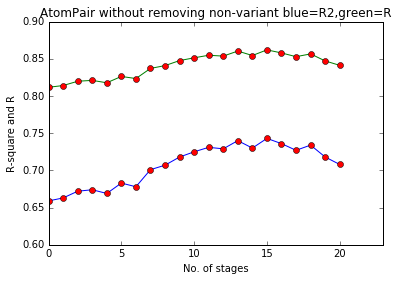

In [47]:
plt.xlabel('No. of stages')#('No. of attributes')
plt.ylabel('R-square and R')
plt.title('AtomPair without removing non-variant blue=R2,green=R')
#attributes = [2048,1848,1648,1448,1248,1048,848,648,448,248]
attributes = list(range(21))
plt.plot(attributes, plainr2s)
plt.plot(attributes, plainr2s,'ro')
plt.plot(attributes, plainrs)
plt.plot(attributes, plainrs,'ro')
plt.axis([0,23, 0.6, 0.9])



[0, 23, 0, 0.006]

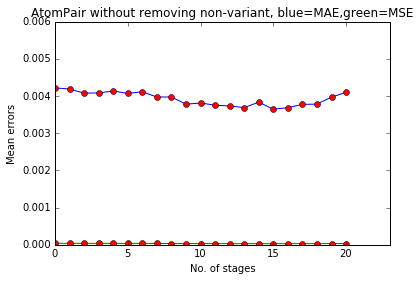

In [72]:
plt.xlabel('No. of stages')
plt.ylabel('Mean errors')
plt.title('AtomPair without removing non-variant, blue=MAE,green=MSE')
#attributes = [2048,1848,1648,1448,1248,1048,848,648,448,248]
attributes = list(range(21))
plt.plot(attributes, plainmaes)
plt.plot(attributes, plainmaes,'ro')
plt.plot(attributes, plainmses)
plt.plot(attributes, plainmses,'ro')
plt.axis([0, 23, 0, 0.006])


##  Drawing Board

In [114]:
yTypes = ['HOMO','LUMO','GAP']
functionals = ['B3LYP','PBE','PB86','M06']
# for yType in yTypes:
yType = 'LUMO'
functional = 'M06'
# for functional in functionals:
prefix = yType+'_AtomPair_randomForest_'+functional+'_supervised'
editedrs,editedr2s = [],[]

plainmaes,editedmaes = [],[]

maxVal, maxStep,maxAv = 0,0,0
for i in range(21):
#     print 'Step',i+1
#     print "+++++++++++++++++++++++++++++++"

    editedData = loadData(prefix+str(i),'regMetrics')
#     data = loadData(prefix+str(i),'supervised')
#     print "AtomPair after removing non-variant columns :",editedData['r2']


    editedr2s += [editedData['r2']]
    editedrs += [editedData['r']]
    editedmaes += [editedData['MAE']]

    if maxVal<editedData['r2']:
        maxVal = editedData['r2']
        maxStep = i
        maxAv = editedData['MAE']

# print yType+'_'+functional+' :',maxVal,ThreeSig(maxAv),maxStep
print yType,functional,'done'
#     print 
#     print "_______________________________"
#     print
editedM06maes = editedmaes

GAP M06 done


[0, 23, 0.55, 0.9]

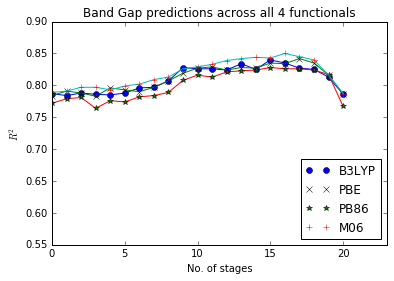

In [100]:
plt.xlabel('No. of stages')
plt.ylabel(r'$R^{2}$')
plt.title('Band Gap predictions across all 4 functionals')
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
l1, = plt.plot(attributes, editedB3LYPr2s)
l2, = plt.plot(attributes, editedB3LYPr2s,'o',color='b',label="B3LYP")
l3, = plt.plot(attributes, editedPBEr2s)
l4, = plt.plot(attributes, editedPBEr2s,'x',color='k',label="PBE")
l5, = plt.plot(attributes, editedPB86r2s)
l6, = plt.plot(attributes, editedPB86r2s,'*',color='g',label="PB86")
l7, = plt.plot(attributes, editedM06r2s)
l8, = plt.plot(attributes, editedM06r2s,'+',color='r',label="M06")

plt.legend(loc='lower right')
plt.axis([0,23, 0.55, 0.9])



[0, 23, 0, 0.008]

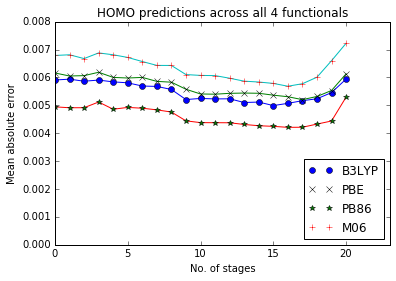

In [117]:
plt.xlabel('No. of stages')
plt.ylabel('Mean absolute error')
plt.title('HOMO predictions across all 4 functionals')
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
l1, = plt.plot(attributes, editedB3LYPmaes)
l2, = plt.plot(attributes, editedB3LYPmaes,'o',color='b',label="B3LYP")
l3, = plt.plot(attributes, editedPBEmaes)
l4, = plt.plot(attributes, editedPBEmaes,'x',color='k',label="PBE")
l5, = plt.plot(attributes, editedPB86maes)
l6, = plt.plot(attributes, editedPB86maes,'*',color='g',label="PB86")
l7, = plt.plot(attributes, editedM06maes)
l8, = plt.plot(attributes, editedM06maes,'+',color='r',label="M06")

plt.legend(loc='lower right')
plt.axis([0,23, 0, 0.008])

[0, 23, 0, 0.008]

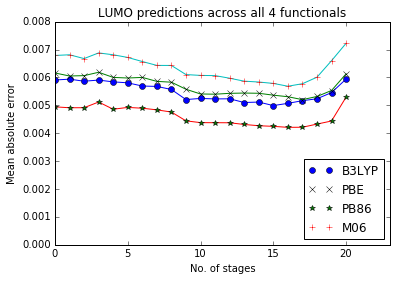

In [118]:
plt.xlabel('No. of stages')
plt.ylabel('Mean absolute error')
plt.title('LUMO predictions across all 4 functionals')
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
l1, = plt.plot(attributes, editedB3LYPmaes)
l2, = plt.plot(attributes, editedB3LYPmaes,'o',color='b',label="B3LYP")
l3, = plt.plot(attributes, editedPBEmaes)
l4, = plt.plot(attributes, editedPBEmaes,'x',color='k',label="PBE")
l5, = plt.plot(attributes, editedPB86maes)
l6, = plt.plot(attributes, editedPB86maes,'*',color='g',label="PB86")
l7, = plt.plot(attributes, editedM06maes)
l8, = plt.plot(attributes, editedM06maes,'+',color='r',label="M06")

plt.legend(loc='lower right')
plt.axis([0,23, 0, 0.008])

[0, 23, 0, 0.008]

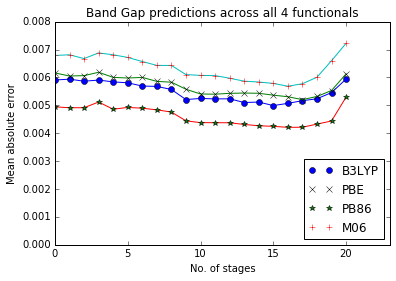

In [116]:
plt.xlabel('No. of stages')
plt.ylabel('Mean absolute error')
plt.title('Band Gap predictions across all 4 functionals')
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
l1, = plt.plot(attributes, editedB3LYPmaes)
l2, = plt.plot(attributes, editedB3LYPmaes,'o',color='b',label="B3LYP")
l3, = plt.plot(attributes, editedPBEmaes)
l4, = plt.plot(attributes, editedPBEmaes,'x',color='k',label="PBE")
l5, = plt.plot(attributes, editedPB86maes)
l6, = plt.plot(attributes, editedPB86maes,'*',color='g',label="PB86")
l7, = plt.plot(attributes, editedM06maes)
l8, = plt.plot(attributes, editedM06maes,'+',color='r',label="M06")

plt.legend(loc='lower right')
plt.axis([0,23, 0, 0.008])

[0, 23, 0, 0.006]

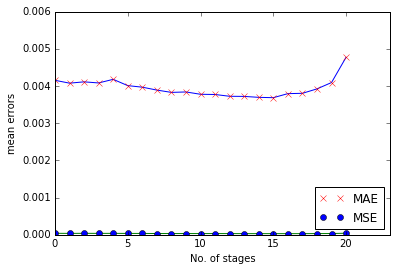

In [71]:
plt.xlabel('No. of stages')
plt.ylabel('mean errors')
# plt.title('AtomPair blue=MAE,green=MSE')
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
plt.plot(attributes, editedmaes)
plt.plot(attributes, editedmaes,'x',color='r',label="MAE")
plt.plot(attributes, editedmses)
plt.plot(attributes, editedmses,'o',color='b',label="MSE")
plt.legend(loc='lower right')
plt.axis([0,23, 0, 0.006])

[0, 23, 0.55, 0.9]

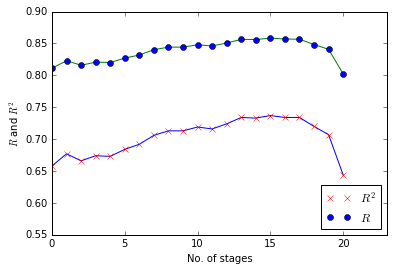

In [ ]:
plt.xlabel('No. of stages')
plt.ylabel(r'$R$ and $R^{2}$')
# plt.title('AtomPair blue=MAE,green=MSE')
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
plt.plot(attributes, editedr2s)
plt.plot(attributes, editedr2s,'x',color='r',label=r'$R^{2}$')
plt.plot(attributes, editedrs)
plt.plot(attributes, editedrs,'o',color='b',label=r'$R$')
plt.legend(loc='lower right')
plt.axis([0,23, 0.55, 0.9])

In [87]:
len(editedr2s)

21

[0, 23, 0, 0.006]

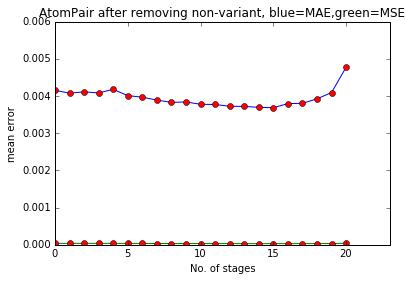

In [52]:
plt.xlabel('No. of stages')
plt.ylabel('mean error')
plt.title('AtomPair after removing non-variant, blue=MAE,green=MSE')
#attributes = [1851,1651,1451,1251,1051,851,651,451,251,51]
attributes = list(range(21))
plt.plot(attributes, editedmaes)
plt.plot(attributes, editedmaes,'ro')
plt.plot(attributes, editedmses)
plt.plot(attributes, editedmses,'ro')
plt.axis([0,23, 0, 0.006])

In [15]:
def scatterplot(realY,predictedY,title="test"):
    x = realY
    y = predictedY
    
    fig = plt.figure()
    
    fig.suptitle(title, fontsize=18)
    plt.xlabel('DFT-derived HOMO', fontsize=16)
    plt.ylabel('predictedHOMO', fontsize=16)
    
    plt.plot(x, numpy.poly1d(numpy.polyfit(x, y, 1))(x),color='red')
    plt.scatter(x,y)
#     figName = title.split("(")[0]+".png"
#     fig.savefig(figName, bbox_inches='tight')
#     plt.close(fig)

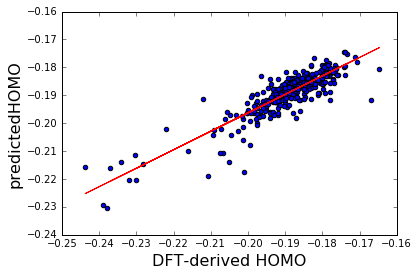

In [17]:
prefix = 'selectedAtomTopo_randomForest_B3LYP_supervised'
predicted = loadData(prefix+str(19),'supervised')['predicted']
actual = loadData('y_full_B3LYP','FP')
scatterplot(actual,predicted,title="")

In [ ]:
yType+'_AtomTopo_randomForest_'+functional+'_supervised'

In [53]:
prefix = 'selectedAtomTopo_randomForest_B3LYP_supervised'
combinedr2s = []
combinedrs = []
combinedmaes = []
combinedmses = []
for i in range(21):
    print 'Step',i+1
    print "+++++++++++++++++++++++++++++++"
    print "Plain AtomPair                              :",loadData(prefix+str(i),'supervised')['r2']
    combinedData = loadData(prefix+str(i),'supervised')
   
    
    combinedr2s += [combinedData['r2']]
    combinedrs += [combinedData['r']]
    combinedmaes += [combinedData['MAE']]
    combinedmses += [combinedData['MSE']]
    
    print 
    print "_______________________________"
    print

Step 1
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.689

_______________________________

Step 2
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.685

_______________________________

Step 3
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.684

_______________________________

Step 4
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.688

_______________________________

Step 5
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.682

_______________________________

Step 6
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.689

_______________________________

Step 7
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.697

_______________________________

Step 8
+++++++++++++++++++++++++++++++
Plain AtomPair                              : 0.698

_______________________________



In [14]:
yTypes = ['HOMO','LUMO','GAP']
functionals = ['B3LYP','PBE','PB86','M06']
# for yType in yTypes:
yType = 'HOMO'
functional = 'M06'
# for functional in functionals:
prefix = yType+'_AtomPair_randomForest_'+functional+'_supervised'
editedrs,editedr2s = [],[]

plainmaes,editedmaes = [],[]

maxVal, maxStep,maxAv = 0,0,0
for i in range(21):
#     print 'Step',i+1
#     print "+++++++++++++++++++++++++++++++"

    editedData = loadData(prefix+str(i),'regMetrics')
#     data = loadData(prefix+str(i),'supervised')
#     print "AtomPair after removing non-variant columns :",editedData['r2']


    editedr2s += [editedData['r2']]
    editedrs += [editedData['r']]
    editedmaes += [editedData['MAE']]

    if maxVal<editedData['r2']:
        maxVal = editedData['r2']
        maxStep = i
        maxAv = editedData['MAE']

print yType+'_'+functional+' :',maxVal,ThreeSig(maxAv),maxStep
print 
#     print 
#     print "_______________________________"
#     print
editedM06r2s = editedr2s

HOMO_M06 : 0.741 0.004 16



In [6]:
yTypes = ['HOMO','LUMO','GAP']
functionals = ['B3LYP','PBE','PB86','M06']
for yType in yTypes:
    for functional in functionals:
        prefix = yType+'_AtomTopo_randomForest_'+functional+'_supervised'
        plainr2s,editedr2s = [],[]
        plainrs,editedrs = [],[]
        plainmaes,editedmaes = [],[]
        plainmses,editedmses = [],[]
        maxVal, maxStep,maxAv = 0,0,0
        predicted = []
        for i in range(20):
        #     print 'Step',i+1
        #     print "+++++++++++++++++++++++++++++++"
            try:
                editedData = loadData(prefix+str(i),'regMetricsComb')
            except:
                continue
        #     data = loadData(prefix+str(i),'supervised')
        #     print "AtomPair after removing non-variant columns :",editedData['r2']


            editedr2s += [editedData['r2']]
            editedrs += [editedData['r']]
            editedmaes += [editedData['MAE']]
            editedmses += [editedData['MSE']]
            if maxVal<editedData['r2']:
                maxVal = editedData['r2']
                maxStep = i
                maxAv = editedData['MAE']
                predicted = editedData['predicted']

        print yType+'_'+functional+' :',maxVal,ThreeSig(maxAv),maxStep
    print 
#     print 
#     print "_______________________________"
#     print

HOMO_B3LYP : 0.679 0.004 0
HOMO_PBE : 0 0.0 0
HOMO_PB86 : 0.745 0.003 12
HOMO_M06 : 0.732 0.004 12

LUMO_B3LYP : 0.808 0.005 12
LUMO_PBE : 0.805 0.005 11
LUMO_PB86 : 0.802 0.004 12
LUMO_M06 : 0.813 0.005 12

GAP_B3LYP : 0.843 0.005 12
GAP_PBE : 0.838 0.005 12
GAP_PB86 : 0 0.0 0
GAP_M06 : 0.839 0.006 12



In [21]:
editedData['predicted']

[0.15601874805952376,
 0.1603407722301588,
 0.13899202726984128,
 0.15046547699603177,
 0.13868153368650796,
 0.15790329451190477,
 0.14157302689646464,
 0.15369730552380945,
 0.13914792386111111,
 0.14676123559632032,
 0.1523361967738095,
 0.14740094044083693,
 0.26283631904761884,
 0.14919319152128435,
 0.13656875823520928,
 0.14438586442063489,
 0.15521286073015877,
 0.18080265294841261,
 0.15392446866017315,
 0.1423468344047619,
 0.15733113242857141,
 0.15560784436111108,
 0.15139413354761902,
 0.14373859535714284,
 0.15067132459523813,
 0.13678910753205131,
 0.14358822357539683,
 0.12229357233333334,
 0.13831929944228002,
 0.17872738971176041,
 0.15010644677777774,
 0.16169080721031748,
 0.15149633989682537,
 0.16072085108730166,
 0.14096344208333331,
 0.16903975084126985,
 0.14978424785569988,
 0.16086274626515157,
 0.14827589069841274,
 0.14476452373809523,
 0.14435366096825389,
 0.15663567364285721,
 0.14392489325396826,
 0.21435722041269845,
 0.15188372986363638,
 0.1494664196

[0, 23, 0.6, 0.9]

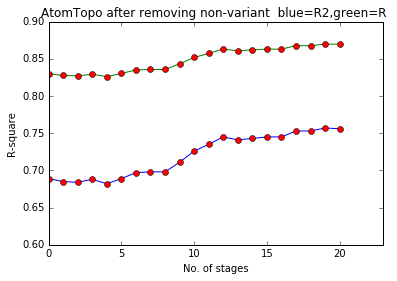

In [54]:
plt.xlabel('No. of stages')
plt.ylabel('R-square')
plt.title('AtomTopo after removing non-variant  blue=R2,green=R ')
#attributes = [2499,2299,2099,1899,1699,1499]
attributes = list(range(21))
plt.plot(attributes, combinedr2s)
plt.plot(attributes, combinedr2s,'ro')
plt.plot(attributes, combinedrs)
plt.plot(attributes, combinedrs,'ro')
plt.axis([0, 23, 0.6, 0.9])


[0, 23, 0, 0.006]

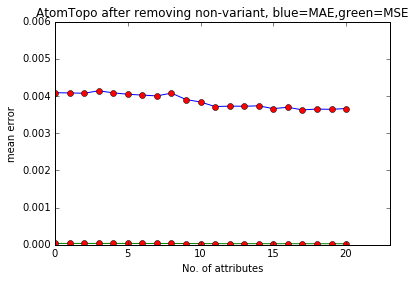

In [55]:
plt.xlabel('No. of attributes')
plt.ylabel('mean error')
plt.title('AtomTopo after removing non-variant, blue=MAE,green=MSE')
#attributes = [2499,2299,2099,1899,1699,1499]
attributes = list(range(21))
plt.plot(attributes, combinedmaes)
plt.plot(attributes, combinedmaes,'ro')
plt.plot(attributes, combinedmses)
plt.plot(attributes, combinedmses,'ro')
plt.axis([0,23, 0, 0.006])

In [56]:
prefix = 'AtomPair_randomForest_B3LYP_sparse_pca'
sparser2s = []
sparsers = []
sparsemaes = []
sparsemses = []
scores = [0.6,0.7,0.75,0.8,0.85,0.9,0.95,0.99]
for score in scores:
    print 'Score',score
    print "+++++++++++++++++++++++++++++++"
    print "SParse PCA AtomPair                              :",loadData(prefix+str(score),'SPCA')['r2']
    sparseData = loadData(prefix+str(score),'SPCA')
   
    
    sparser2s += [combinedData['r2']]
    sparsers += [combinedData['r']]
    sparsemaes += [combinedData['MAE']]
    sparsemses += [combinedData['MSE']]
    
    print 
    print "_______________________________"
    print

Score 0.6
+++++++++++++++++++++++++++++++
SParse PCA AtomPair                              : 0.57

_______________________________

Score 0.7
+++++++++++++++++++++++++++++++
SParse PCA AtomPair                              : 0.568

_______________________________

Score 0.75
+++++++++++++++++++++++++++++++
SParse PCA AtomPair                              : 0.542

_______________________________

Score 0.8
+++++++++++++++++++++++++++++++
SParse PCA AtomPair                              : 0.573

_______________________________

Score 0.85
+++++++++++++++++++++++++++++++
SParse PCA AtomPair                              : 0.571

_______________________________

Score 0.9
+++++++++++++++++++++++++++++++
SParse PCA AtomPair                              : 0.567

_______________________________

Score 0.95
+++++++++++++++++++++++++++++++
SParse PCA AtomPair                              : 0.537

_______________________________

Score 0.99
+++++++++++++++++++++++++++++++
SParse PCA AtomPair     

[0, 23, 0.6, 0.9]

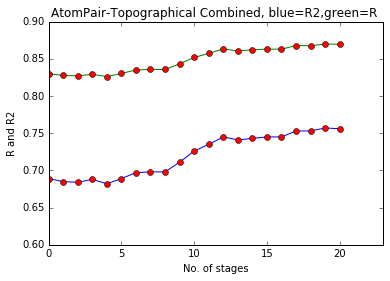

In [57]:
plt.xlabel('No. of stages')
plt.ylabel('R and R2')
plt.title('AtomPair-Topographical Combined, blue=R2,green=R ')
#attributes = [2499,2299,2099,1899,1699,1499]
attributes = list(range(21))
plt.plot(attributes, combinedr2s)
plt.plot(attributes, combinedr2s,'ro')
plt.plot(attributes, combinedrs)
plt.plot(attributes, combinedrs,'ro')
plt.axis([0, 23, 0.6, 0.9])


[0, 23, 0, 0.006]

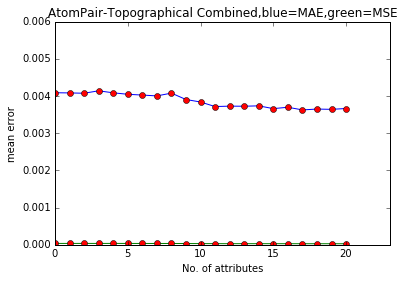

In [58]:
plt.xlabel('No. of attributes')
plt.ylabel('mean error')
plt.title('AtomPair-Topographical Combined,blue=MAE,green=MSE')
#attributes = [2499,2299,2099,1899,1699,1499]
attributes = list(range(21))
plt.plot(attributes, combinedmaes)
plt.plot(attributes, combinedmaes,'ro')
plt.plot(attributes, combinedmses)
plt.plot(attributes, combinedmses,'ro')
plt.axis([0,23, 0, 0.006])

In [117]:
for i in range(10):
    data = loadData('selectedAtomTopo_randomForest_B3LYP_supervised'+str(i),'supervised')
    print data['best_grid']

{'max_features': 0.33, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 25}
{'max_features': 0.33, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 25}
{'max_features': 0.25, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 25}
{'max_features': 0.25, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 10}
{'max_features': 0.25, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 25}
{'max_features': 0.25, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 25}
{'max_features': 0.33, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 100, 'max_depth': 25}
{'max_features': 0.33, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 25}
{'max_features': 0.25, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 10}
{'max_features': 0.25, 'min_samples_split': 5, 'n_jobs': -1, 'n_estimators': 200, 'max_depth': 25}


In [5]:
import csv
import csv
reader = csv.reader(open('allFunctionals.csv'),delimiter='|')

HOMOB3LYP,HOMOPBE,HOMOPB86,HOMOM06 = [],[],[],[]
LUMOB3LYP,LUMOPBE,LUMOPB86,LUMOM06 = [],[],[],[]
GAPB3LYP,GAPPBE,GAPPB86,GAPM06 = [],[],[],[]
a,b,c,d = 6,9,12,15
result = {}
for row in reader:
    row = row[1:]
    if 'M06' in row or 'SMILES' in row:
        continue
    print row
    HOMOB3LYP += [float(row[a])]
    HOMOPBE += [float(row[b])]
    HOMOPB86 += [float(row[c])]
    HOMOM06 += [float(row[d])]
    
    LUMOB3LYP += [float(row[a+1])]
    LUMOPBE += [float(row[b+1])]
    LUMOPB86 += [float(row[c+1])]
    LUMOM06 += [float(row[d+1])]
    
    GAPB3LYP += [float(row[a+2])]
    GAPPBE += [float(row[b+2])]
    GAPPB86 += [float(row[c+2])]
    GAPM06 += [float(row[d+2])]
    
    
    
#     key = row[0]
#     print key
#     if key in result:
#         # implement your duplicate row handling here
#         pass
#     result[key] = row
# # print result
#LUMO B3LYP:7, PBE:10,PB86:13, M06:16

['Cc1ccc(c2c3cc(c4ccc(c5sc(c6cccs6)c6cc(S(=O)(=O)C)sc56)s4)sc3c(c3ccc(C)s3)c3ccsc23)s1', 'Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', 'InChI=1S/C35H22O2S9/c1-17-6-8-23(40-17)29-19-12-14-39-32(19)30(24-9-7-18(2)41-24)20-15-27(43-33(20)29)22-10-11-26(42-22)35-34-21(16-28(44-34)46(3,36)37)31(45-35)25-5-4-13-38-25/h4-16H,1-3H3', '10.1021/ar5000743,BOUZSMSNJFUUCG-UHFFFAOYSA-N,polymer,bulk,PC71BM,-5.04,-3.57,1.47,1.59,7.81,0.69,17.07,66.3', 'Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1', '18', '-0.186833', '-0.0987778', '0.0880556', '-0.196389', '-0.0985', '0.0978889', '-0.170778', '-0.118333', '0.0524444', '-0.227389', '-0.0765', '0.150889']
['CN1c2ccccc2C(=C2c3ccc(c4cccs4)cc3N(C)C2=O)C1=O', 'CN1c2ccccc2C(=C2c3ccc(-c4cccs4)cc3N(C)C2=O)C1=O', 'InChI=1S/C22H16N2O2S/c1-23-16-7-4-3-6-14(16)19(21(23)25)20-15-10-9-13(18-8-5-11-27-18)12-17(15)24(2)22(20)26/h3-12H,1-2H3/b20-19+', '10.1039/C3PY01598J,PAPOKCO

In [153]:
def supervisedTransform(X_train,estimator,featureReduce=20):
    features = estimator.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],
                 axis=0)
    indices = np.argsort(importances)[::-1]
    reducedIndices = indices[:len(indices)-featureReduce]
    X_train_reduced = []

    for row in X_train:
        row_reduced = [row[i] for i in reducedIndices]
        X_train_reduced += [row_reduced]

    return X_train_reduced

In [163]:
def TwoSig(x):
    return float("{0:.2f}".format(x))

def ThreeSig(x):
    return float("{0:.3f}".format(x))

In [116]:
HOMOB3LYP

[-0.186833,
 -0.20325,
 -0.188611,
 -0.173267,
 -0.186,
 -0.194,
 -0.1845,
 -0.1836,
 -0.194091,
 -0.187889,
 -0.196,
 -0.195083,
 -0.23,
 -0.179933,
 -0.176444,
 -0.183167,
 -0.184421,
 -0.201333,
 -0.181,
 -0.18215,
 -0.178,
 -0.183,
 -0.176278,
 -0.183467,
 -0.237211,
 -0.18485,
 -0.185,
 -0.180059,
 -0.171118,
 -0.1884,
 -0.193937,
 -0.189077,
 -0.181167,
 -0.190588,
 -0.191467,
 -0.195167,
 -0.179187,
 -0.182786,
 -0.185929,
 -0.18075,
 -0.179882,
 -0.185143,
 -0.18,
 -0.197667,
 -0.1916,
 -0.1932,
 -0.1765,
 -0.187286,
 -0.1841,
 -0.197625,
 -0.19,
 -0.195182,
 -0.1805,
 -0.22825,
 -0.209,
 -0.189,
 -0.1929,
 -0.184071,
 -0.176579,
 -0.192421,
 -0.187125,
 -0.192706,
 -0.19325,
 -0.190941,
 -0.194,
 -0.164667,
 -0.195875,
 -0.196467,
 -0.190867,
 -0.190154,
 -0.188625,
 -0.1822,
 -0.2014,
 -0.174133,
 -0.189467,
 -0.196615,
 -0.204636,
 -0.187846,
 -0.238,
 -0.2068,
 -0.189765,
 -0.1995,
 -0.179842,
 -0.185875,
 -0.19245,
 -0.187,
 -0.192706,
 -0.185923,
 -0.188636,
 -0.201,
 -0.

In [159]:
def saveNewResults(funcType, fpType, regType, best_metric,best_grid, best_estimator,best_predict,cum_score):
	dictionary = {}
	dictionary['r2']= ThreeSig(best_metric[0])
	dictionary['r']= best_metric[1]
	dictionary['MSE']= best_metric[2]
	dictionary['RMSE']= best_metric[3]
	dictionary['MAE']= best_metric[4]
	dictionary['MAPE']= best_metric[5]
	dictionary['cum_score'] = cum_score
	dictionary['best_grid'] = best_grid
	dictionary['best_estimator'] = best_estimator
	dictionary['predicted'] = best_predict

	fileName = fpType+"_"+regType+"_"+funcType+"_"+'supervised'+str(cum_score)
	saveData(dictionary,fileName,"regMetrics")
	print best_metric[0],best_estimator
	print "result saved in ",fileName

In [174]:
def runModifiedSupervisedGrid(yType,funcType,fpType="AtomPair",regType="randomForest"):

    regType = 'randomForest'
    print fpType
    for idx in range(21):
        print
        print 'Step',idx+1,'of the supervised feature selection'
        print '_________________________________________'
        print
        if idx ==0:
            X_full = loadData("X_full_"+fpType,"FP")
        else:
            X_full = loadData("X_full_"+fpType+str(idx),"supervised")
        y_true = array(loadData(yType+'_'+funcType,"FP"))
        bestParam = loadData('selectedAtomTopo_randomForest_B3LYP_supervised'+str(idx),'supervised')['best_grid']

        estimator = getEstimator(regType)

        best_estimator,best_grid,best_metric,best_predict = modRegressor(X_full,y_true,estimator,bestParam)

        if idx<9:
            featureReduce = 200
        else:
            featureReduce = 20

        X_full_reduced = supervisedTransform(X_full, best_grid,featureReduce)
        print len(X_full_reduced),len(X_full_reduced[0])
        saveData(X_full_reduced,'X_full_'+fpType+str(idx+1),'supervised')
        saveNewResults(funcType, fpType, regType, best_metric,best_grid, best_estimator,best_predict,idx)

    return


In [161]:
def modRegressor(X_full,y_full,estimator,bestParam):
    
    estimator.set_params(**bestParam)
    y_predict = []
    y_true = y_full
    loo = cross_validation.LeaveOneOut(len(X_full))
    count = 0
    for train_index, test_index in loo:
        count += 1
        X_train, X_test = X_full[train_index], X_full[test_index]
        y_train, y_test = y_full[train_index], y_full[test_index]
        predicted = estimator.fit(X_train, y_train).predict(X_test)
        print "[",count,"] estimator running ....."
        y_predict += [predicted[0]]

    score = r2_score(y_true,y_predict)
    R = r_score(y_true,y_predict)
    MSE = mean_squared_error(y_true, y_predict)
    RMSE = root_mean_squared_error(y_true,y_predict)
    MAE = mean_absolute_error(y_true, y_predict)
    MAPE = mean_absolute_percentage_error(y_true, y_predict)
    
    best_grid = bestParam
    best_estimator = estimator
    best_metric = [score, R, MSE, RMSE, MAE,MAPE]
    best_predict = y_predict
    
    return best_metric,best_grid,best_estimator,best_predict

In [166]:
fpType = 'AtomPair'
funcType = 'B3LYP'
regType = 'randomForest'
yType = 'LUMO'
idx = 0
X_full = loadData("X_full_"+fpType,"FP")
y_true = array(loadData(yType+'_'+funcType,"FP"))
bestParam = loadData('selectedAtomTopo_randomForest_B3LYP_supervised'+str(idx),'supervised')['best_grid']
estimator = getEstimator(regType)
best_estimator,best_grid,best_metric,best_predict = modRegressor(X_full,y_true,estimator,bestParam)
featureReduce = 200


[ 1 ] estimator running .....
[ 2 ] estimator running .....
[ 3 ] estimator running .....
[ 4 ] estimator running .....
[ 5 ] estimator running .....
[ 6 ] estimator running .....
[ 7 ] estimator running .....
[ 8 ] estimator running .....
[ 9 ] estimator running .....
[ 10 ] estimator running .....
[ 11 ] estimator running .....
[ 12 ] estimator running .....
[ 13 ] estimator running .....
[ 14 ] estimator running .....
[ 15 ] estimator running .....
[ 16 ] estimator running .....
[ 17 ] estimator running .....
[ 18 ] estimator running .....
[ 19 ] estimator running .....
[ 20 ] estimator running .....
[ 21 ] estimator running .....
[ 22 ] estimator running .....
[ 23 ] estimator running .....
[ 24 ] estimator running .....
[ 25 ] estimator running .....
[ 26 ] estimator running .....
[ 27 ] estimator running .....
[ 28 ] estimator running .....
[ 29 ] estimator running .....
[ 30 ] estimator running .....
[ 31 ] estimator running .....
[ 32 ] estimator running .....
[ 33 ] estimator 

In [173]:
best_metric

{'max_depth': 25,
 'max_features': 0.33,
 'min_samples_split': 5,
 'n_estimators': 100,
 'n_jobs': -1}

In [175]:
runModifiedSupervisedGrid('GAP','PB86')

AtomPair

Step 1 of the supervised feature selection
_________________________________________

[ 1 ] estimator running .....
[ 2 ] estimator running .....
[ 3 ] estimator running .....
[ 4 ] estimator running .....
[ 5 ] estimator running .....
[ 6 ] estimator running .....
[ 7 ] estimator running .....
[ 8 ] estimator running .....
[ 9 ] estimator running .....
[ 10 ] estimator running .....
[ 11 ] estimator running .....
[ 12 ] estimator running .....
[ 13 ] estimator running .....
[ 14 ] estimator running .....
[ 15 ] estimator running .....
[ 16 ] estimator running .....
[ 17 ] estimator running .....
[ 18 ] estimator running .....
[ 19 ] estimator running .....
[ 20 ] estimator running .....
[ 21 ] estimator running .....
[ 22 ] estimator running .....
[ 23 ] estimator running .....
[ 24 ] estimator running .....
[ 25 ] estimator running .....
[ 26 ] estimator running .....
[ 27 ] estimator running .....
[ 28 ] estimator running .....
[ 29 ] estimator running .....
[ 30 ] estimat

TypeError: only integer arrays with one element can be converted to an index

In [165]:
best_metric

{'max_depth': 25,
 'max_features': 0.33,
 'min_samples_split': 5,
 'n_estimators': 100,
 'n_jobs': -1}

In [1]:
Input = 'Cc1ccc(-c2c3cc(-c4ccc(-c5sc(-c6cccs6)c6cc(S(C)(=O)=O)sc65)s4)sc3c(-c3ccc(C)s3)c3ccsc32)s1' 
features = generateFeatures(Input)
model = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
           max_features=0.33, max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=20, min_weight_fraction_leaf=0.0,
           n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)


NameError: name 'RandomForestRegressor' is not defined

In [121]:
first = loadData('X_full_MACCS','FP')[0]

In [131]:
second = loadData('X_full_MACCS','FP')[1]

In [133]:
first = first.astype(int)
second = second.astype(int)

In [127]:
first

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 1, 0])

In [130]:
print ''.join(map(str, first))

00000000000000000000000000000000000010000000000000010001001111101001000001000000010100001000010010000110010000001000000010001100001000001100010000001100000000011011110


In [136]:
print ''.join(map(str, second))

00000000000000000000000000000000000010000000000000100000000000100000000000011000010101001000110010010100010000100000010011100101000000011100001111001110001010111111110


In [132]:
from sklearn.metrics import jaccard_similarity_score

In [134]:
jaccard_similarity_score(first, second)

0.79041916167664672

In [137]:
from math import log

In [3]:
prefix = 'AtomPair_randomForest_B3LYP_supervised'
data = loadData(prefix+str(0),'supervised')
data

{'MAE': 0.0042185616181042943,
 'MAPE': 2.1913027336986461,
 'MSE': 4.0110333098243562e-05,
 'RMSE': 0.0063332719109669977,
 'best_estimator': RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=25,
            max_features=0.33, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=20, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
 'best_grid': {'max_depth': 10,
  'max_features': 0.25,
  'min_samples_split': 5,
  'n_estimators': 100,
  'n_jobs': -1},
 'cum_score': 0,
 'predicted': [-0.18665924753264673,
  -0.18955421564455599,
  -0.18676340058022309,
  -0.17805981426238129,
  -0.18676240873638897,
  -0.19400226390438077,
  -0.18505161342925752,
  -0.18824673589058874,
  -0.18554953167454419,
  -0.18716129909782864,
  -0.19350424255160267,
  -0.19370133450731916,
  -0.22179523507142854,
  -0.1843066168754762,
  -0.18012044384624912,
  -0.17973002804381619